# Érzelemfelismerés beszédet leíró manuális jellemzőkkel

Ebben a Demo-ban az érzelmek felismerésével ismerkedhetünk meg beszédből. Az adatbázis 38 beszélőt tartalmaz, akik magyar nyelven a "Kovács Katival szeretnék beszélni" szöveget monták be 8 érzelmi állapot imitálásával. Ezen érzelmek a szomorúság, harag, félelem, izgatottság, undor, megelettség, öröm és semeleges.

Az első lépés a *szükséges csomagok* betöltése.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa

from sklearn import metrics
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.manifold import TSNE

Ezután az elérési utat adjuk meg az adatbázishoz. Az adatbázist szűrjük a fent leírt beszédmintákra (magyar nyelv és 1. feladat). A célcímkéket eltároljuk a *labels* változóban.

In [5]:
!wget http://lsa.tmit.bme.hu/files/HungarianEmotionalSentences.zip
!unzip HungarianEmotionalSentences.zip

--2023-11-08 20:15:04--  http://lsa.tmit.bme.hu/files/HungarianEmotionalSentences.zip
Resolving lsa.tmit.bme.hu (lsa.tmit.bme.hu)... 152.66.246.99
Connecting to lsa.tmit.bme.hu (lsa.tmit.bme.hu)|152.66.246.99|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62600577 (60M) [application/x-zip-compressed]
Saving to: ‘HungarianEmotionalSentences.zip’

HungarianEmotionalS 100%[===================>]  59.70M  9.36MB/s    in 7.3s    

2023-11-08 20:15:13 (8.13 MB/s) - ‘HungarianEmotionalSentences.zip’ saved [62600577/62600577]

Archive:  HungarianEmotionalSentences.zip
  inflating: readme.txt              
  inflating: F0001B_hu.wav           
  inflating: F0001D_hu.wav           
  inflating: F0001I_hu.wav           
  inflating: F0001L_hu.wav           
  inflating: F0001M_hu.wav           
  inflating: F0001O_hu.wav           
  inflating: F0001S_hu.wav           
  inflating: F0002B_hu.wav           
  inflating: F0002D_hu.wav           
  inflating: F0002F_hu.wav  

In [6]:
!ls

F0001B_hu.wav  F2041D_hu.wav  F3023D_hu.wav		       M0033I_hu.wav  M2033M_hu.wav
F0001D_hu.wav  F2041I_hu.wav  F3023I_hu.wav		       M0033L_hu.wav  M2033S_hu.wav
F0001I_hu.wav  F2041L_hu.wav  F3023L_hu.wav		       M0033M_hu.wav  M2091D_hu.wav
F0001L_hu.wav  F2041M_hu.wav  F3023M_hu.wav		       M0033O_hu.wav  M2091F_hu.wav
F0001M_hu.wav  F2041O_hu.wav  F3023O_hu.wav		       M0033S_hu.wav  M2091I_hu.wav
F0001O_hu.wav  F2041S_hu.wav  F3023S_hu.wav		       M0061B_hu.wav  M2091L_hu.wav
F0001S_hu.wav  F2042B_hu.wav  F3031D_hu.wav		       M0061D_hu.wav  M2091M_hu.wav
F0002B_hu.wav  F2042D_hu.wav  F3031F_hu.wav		       M0061F_hu.wav  M2091O_hu.wav
F0002D_hu.wav  F2042I_hu.wav  F3031I_hu.wav		       M0061I_hu.wav  M2091S_hu.wav
F0002F_hu.wav  F2042L_hu.wav  F3031L_hu.wav		       M0061L_hu.wav  M2092F_hu.wav
F0002I_hu.wav  F2042O_hu.wav  F3031M_hu.wav		       M0061M_hu.wav  M2092I_hu.wav
F0002L_hu.wav  F2042S_hu.wav  F3031O_hu.wav		       M0061O_hu.wav  M2092S_hu.wav
F0002M_hu.wav  F2043B_hu.wav

In [7]:
DATA_PATH = "/content/"

file_names = sorted(i for i in os.listdir(DATA_PATH) if i.endswith("_hu.wav") and i[4] == '1')
file_paths = [os.path.join(DATA_PATH, name) for name in file_names]
labels = []

for name in file_names:
    labels.append(name.split(".")[0].split("_")[0][-1])

A címkék a *my_dict* szerinti egy betűs kódolásban vannak a labels *változóban*. Ezeket átalakítjuk számunkra értelmezhetőbb címkékké.

In [8]:
my_dict = {
    'B': "sadness",
    'D': "anger",
    'F': "fear",
    'I': "excitement",
    'L': "disgust",
    'M': "suprise",
    'O': "joy",
    'S': "neutral"
}

for i in range(len(labels)):
    if labels[i] in my_dict:
        labels[i] = my_dict[labels[i]]

A jellemzőkinyerésre a **surfboard** csomagot használjuk. Itt megadhatjuk, hogy mely beszédet leíró jellemzőkre van szükségünk. Ez ebben az esetben az *MFCC* értékek átlaga és szórás a teljes beszédfelvételre nézve. A surfboard bemenete maguk a handfelvételek.

In [9]:
X = pd.DataFrame()
for file in file_paths:
    y, sr = librosa.load(path=file)
    feature_dataframe = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    feature_dataframe = np.mean(feature_dataframe, axis = -1)
    X = X.append(pd.DataFrame(feature_dataframe).T)

<ipython-input-9-50de04324833>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X = X.append(pd.DataFrame(feature_dataframe).T)
<ipython-input-9-50de04324833>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X = X.append(pd.DataFrame(feature_dataframe).T)
<ipython-input-9-50de04324833>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X = X.append(pd.DataFrame(feature_dataframe).T)
<ipython-input-9-50de04324833>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X = X.append(pd.DataFrame(feature_dataframe).T)
<ipython-input-9-50de04324833>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

A kapott jellemzőket standarizáljuk (z = (x - átlag) / szórás) és eltároljuk az *X* változóban. A címkéket egy *y* tömbben tároljuk el.

In [10]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

y = np.array(labels)

Support Vektor Gép modellt fogunk taníani és tesztelni. Ehhez teljes keresztvalidációs eéjárást alkalmazunk, ahol mindig egy elem a teszt elem, a maradék pedig a tanító halmaz. Ez ismétlődik, amíg az összes elem nem volt tesztelem. Tesztelés során  a minta eredeti címkéjét (*orig*) és a bescült címkét (*pred*) eltároljuk.

In [23]:
loo = LeaveOneOut()
loo.get_n_splits(X)

orig = []
pred = []

for i, (train_index, test_index) in enumerate(loo.split(X)):

    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    clf = svm.SVC(kernel = 'linear', C = 13, probability=(False))
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    orig.append(y_test[0])
    pred.append(y_pred)

Végül egy *tévesztési mátrixon* és egy *reporton* keresztül vizsgálhatjuk a modellek teljesítményét.

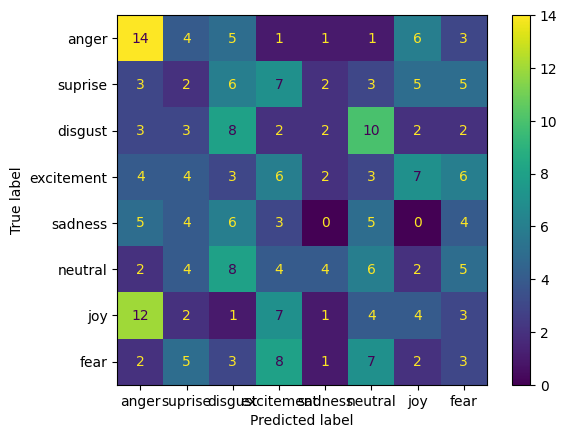

In [24]:
cm = metrics.confusion_matrix(orig, pred, labels=list(set(labels)))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(labels)))
disp.plot()
plt.show()

In [25]:
print(metrics.classification_report(orig, pred, target_names=list(set(labels))))

              precision    recall  f1-score   support

       anger       0.31      0.40      0.35        35
     suprise       0.20      0.25      0.22        32
     disgust       0.16      0.17      0.16        35
  excitement       0.10      0.10      0.10        31
     sadness       0.14      0.12      0.13        34
     neutral       0.15      0.17      0.16        35
         joy       0.00      0.00      0.00        27
        fear       0.07      0.06      0.07        33

    accuracy                           0.16       262
   macro avg       0.14      0.16      0.15       262
weighted avg       0.15      0.16      0.15       262



Vizuális betekintést tehetünk a jellemzők szeparációs képességébe úgy, hogy dimenziójukat lecsökkentjük (ábrázolható mennyiségre) a minták egymáshoz képesti távolságuk megtartása mellett (t-SNE: t-distributed stochastic neighbor embedding). Az ábrázoláshoz az érzelmeket színkódoljuk egy szótár segítségével.

(-39.24472351074219, 36.73105926513672, -55.78800735473633, 58.32024154663086)

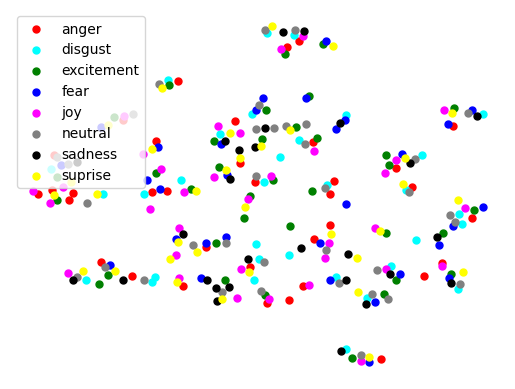

In [26]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(X)

cdict = {
    "sadness": 'black',
    "anger": 'red',
    "fear": 'blue',
    "excitement": 'green',
    "disgust": 'cyan',
    "suprise": 'yellow',
    "joy": 'magenta',
    "neutral": 'gray'
}

for g in np.unique(y):
    ix = np.where(y == g)
    plt.scatter(X_embedded[ix,0], X_embedded[ix,1], c = cdict[g], label = g, s = 25)
plt.legend()
plt.axis('off')